# 🤪 WGANs on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own GAN on the CelebA faces dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, Activation, Dropout, BatchNormalization, LeakyReLU, UpSampling2D, ReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [10]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1=0.5
ADAM_BETA_2=0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = True
ADAM_BETA_1=0.5
ADAM_BETA_2=0.9

## 1. Prepare the data <a name="prepare"></a>

In [11]:
# Load the data
train_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [12]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [13]:
# Show some faces from the training set
train_sample = sample_batch(train)

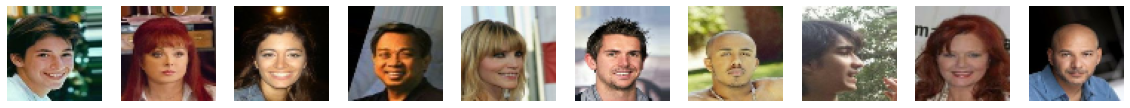

In [14]:
display(train_sample, cmap = None)

## 2. Build the GAN <a name="build"></a>

In [15]:
critic_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = LeakyReLU(0.2)(x)
x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = Flatten()(x)

critic = Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [16]:
generator_input = Input(shape=(Z_DIM,))
x = Reshape((1,1,Z_DIM))(generator_input)
x = Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
generator_output = Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation = 'tanh')(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [17]:
class WGAN(Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = Mean(name="c_wass_loss")
        self.c_gp_metric = Mean(name="c_gp")
        self.c_loss_metric = Mean(name="c_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric,self.g_loss_metric]
    
    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training = True)
                fake_predictions = self.critic(fake_images, training = True)
                real_predictions = self.critic(real_images, training = True)
                
                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight
                
            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}


In [18]:
# Create a GAN
wgan = WGAN(critic=critic, generator=generator, latent_dim=Z_DIM
           , critic_steps = CRITIC_STEPS, gp_weight = GP_WEIGHT)

In [19]:
if LOAD_MODEL:
    wgan.load_weights('./checkpoint/checkpoint.ckpt')

## 3. Train the GAN <a name="train"></a>

In [13]:
# Compile the GAN
wgan.compile(
    c_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)
        

Epoch 1/2000
396/396 [==============================] - ETA: 0s - c_loss: -18.9962 - c_wass_loss: -24.6662 - c_gp: 0.5670 - g_loss: -30.8529
Saved to ./output/generated_img_000.png


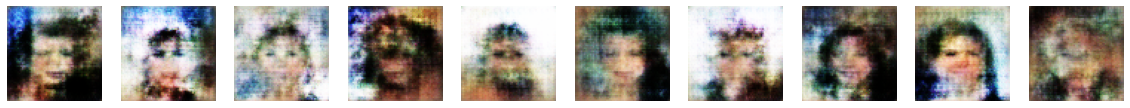

396/396 [==============================] - 1004s 3s/step - c_loss: -18.9962 - c_wass_loss: -24.6662 - c_gp: 0.5670 - g_loss: -30.8529
Epoch 2/2000
396/396 [==============================] - ETA: 0s - c_loss: -8.1839 - c_wass_loss: -9.3091 - c_gp: 0.1125 - g_loss: -50.3370
Saved to ./output/generated_img_001.png


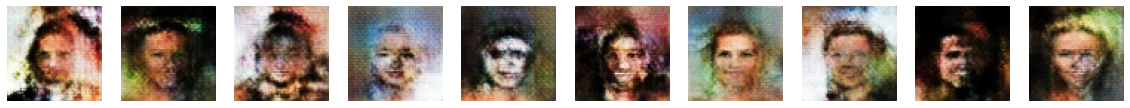

396/396 [==============================] - 995s 3s/step - c_loss: -8.1839 - c_wass_loss: -9.3091 - c_gp: 0.1125 - g_loss: -50.3370
Epoch 3/2000
396/396 [==============================] - ETA: 0s - c_loss: -6.6758 - c_wass_loss: -7.5585 - c_gp: 0.0883 - g_loss: -12.6619
Saved to ./output/generated_img_002.png


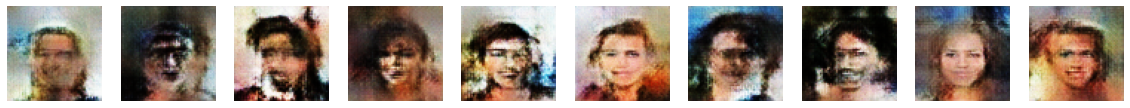

396/396 [==============================] - 995s 3s/step - c_loss: -6.6758 - c_wass_loss: -7.5585 - c_gp: 0.0883 - g_loss: -12.6619
Epoch 4/2000
396/396 [==============================] - ETA: 0s - c_loss: -5.8786 - c_wass_loss: -6.5886 - c_gp: 0.0710 - g_loss: -0.2073
Saved to ./output/generated_img_003.png


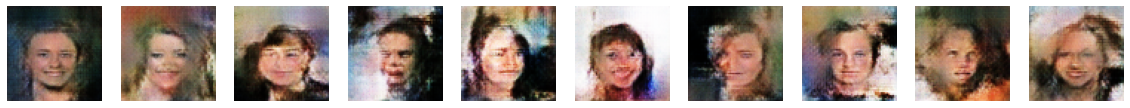

396/396 [==============================] - 994s 3s/step - c_loss: -5.8786 - c_wass_loss: -6.5886 - c_gp: 0.0710 - g_loss: -0.2073
Epoch 5/2000
396/396 [==============================] - ETA: 0s - c_loss: -5.3504 - c_wass_loss: -5.9575 - c_gp: 0.0607 - g_loss: 4.0376
Saved to ./output/generated_img_004.png


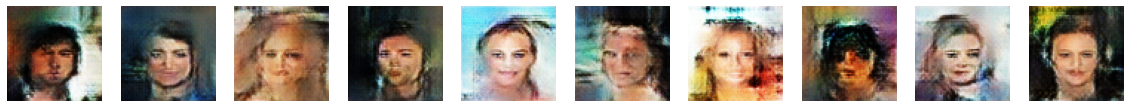

396/396 [==============================] - 995s 3s/step - c_loss: -5.3504 - c_wass_loss: -5.9575 - c_gp: 0.0607 - g_loss: 4.0376
Epoch 6/2000
396/396 [==============================] - ETA: 0s - c_loss: -4.8876 - c_wass_loss: -5.4029 - c_gp: 0.0515 - g_loss: 5.1227
Saved to ./output/generated_img_005.png


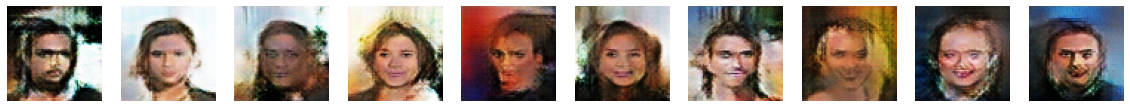

396/396 [==============================] - 995s 3s/step - c_loss: -4.8876 - c_wass_loss: -5.4029 - c_gp: 0.0515 - g_loss: 5.1227
Epoch 7/2000
396/396 [==============================] - ETA: 0s - c_loss: -4.5224 - c_wass_loss: -4.9783 - c_gp: 0.0456 - g_loss: 5.7984
Saved to ./output/generated_img_006.png


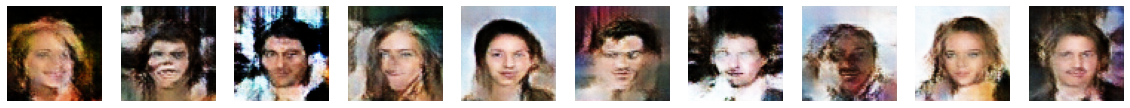

396/396 [==============================] - 996s 3s/step - c_loss: -4.5224 - c_wass_loss: -4.9783 - c_gp: 0.0456 - g_loss: 5.7984
Epoch 8/2000
396/396 [==============================] - ETA: 0s - c_loss: -4.2717 - c_wass_loss: -4.6787 - c_gp: 0.0407 - g_loss: 5.8705
Saved to ./output/generated_img_007.png


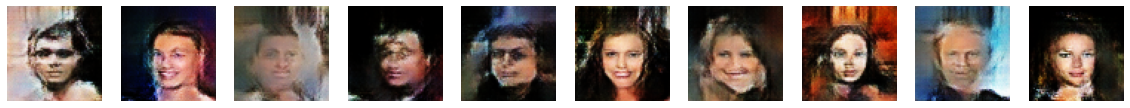

396/396 [==============================] - 995s 3s/step - c_loss: -4.2717 - c_wass_loss: -4.6787 - c_gp: 0.0407 - g_loss: 5.8705
Epoch 9/2000
396/396 [==============================] - ETA: 0s - c_loss: -4.0143 - c_wass_loss: -4.3865 - c_gp: 0.0372 - g_loss: 3.3268
Saved to ./output/generated_img_008.png


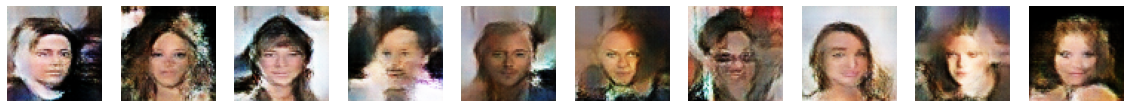

396/396 [==============================] - 995s 3s/step - c_loss: -4.0143 - c_wass_loss: -4.3865 - c_gp: 0.0372 - g_loss: 3.3268
Epoch 10/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.7809 - c_wass_loss: -4.1214 - c_gp: 0.0341 - g_loss: 4.0325
Saved to ./output/generated_img_009.png


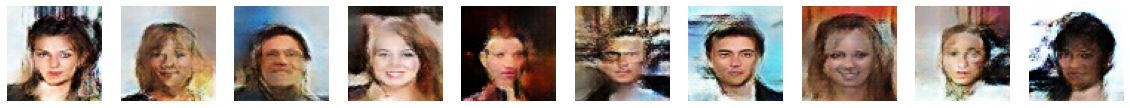

396/396 [==============================] - 995s 3s/step - c_loss: -3.7809 - c_wass_loss: -4.1214 - c_gp: 0.0341 - g_loss: 4.0325
Epoch 11/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.6345 - c_wass_loss: -3.9484 - c_gp: 0.0314 - g_loss: 4.0826
Saved to ./output/generated_img_010.png


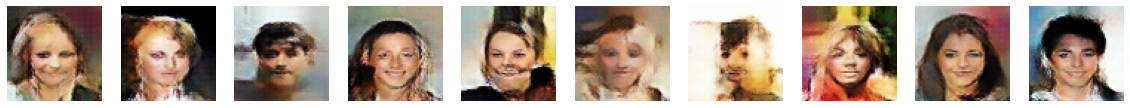

396/396 [==============================] - 996s 3s/step - c_loss: -3.6345 - c_wass_loss: -3.9484 - c_gp: 0.0314 - g_loss: 4.0826
Epoch 12/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.4497 - c_wass_loss: -3.7382 - c_gp: 0.0288 - g_loss: 6.8093
Saved to ./output/generated_img_011.png


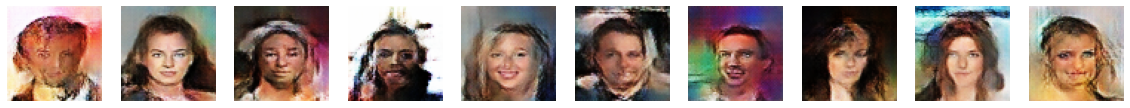

396/396 [==============================] - 995s 3s/step - c_loss: -3.4497 - c_wass_loss: -3.7382 - c_gp: 0.0288 - g_loss: 6.8093
Epoch 13/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.3212 - c_wass_loss: -3.5959 - c_gp: 0.0275 - g_loss: 3.1115
Saved to ./output/generated_img_012.png


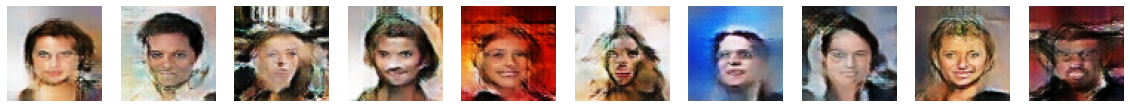

396/396 [==============================] - 994s 3s/step - c_loss: -3.3212 - c_wass_loss: -3.5959 - c_gp: 0.0275 - g_loss: 3.1115
Epoch 14/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.2169 - c_wass_loss: -3.4875 - c_gp: 0.0271 - g_loss: 3.4997
Saved to ./output/generated_img_013.png


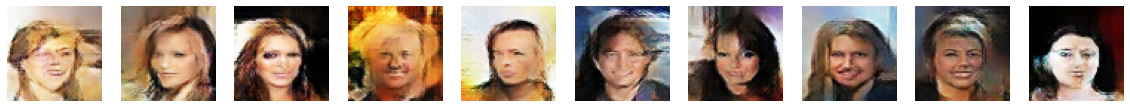

396/396 [==============================] - 994s 3s/step - c_loss: -3.2169 - c_wass_loss: -3.4875 - c_gp: 0.0271 - g_loss: 3.4997
Epoch 15/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.1298 - c_wass_loss: -3.3735 - c_gp: 0.0244 - g_loss: 3.0860
Saved to ./output/generated_img_014.png


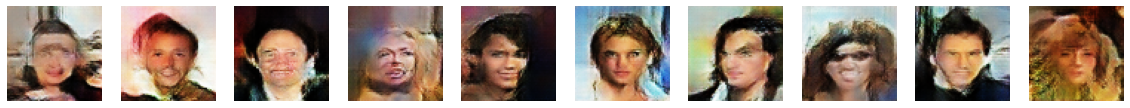

396/396 [==============================] - 995s 3s/step - c_loss: -3.1298 - c_wass_loss: -3.3735 - c_gp: 0.0244 - g_loss: 3.0860
Epoch 16/2000
396/396 [==============================] - ETA: 0s - c_loss: -3.0303 - c_wass_loss: -3.2663 - c_gp: 0.0236 - g_loss: 3.9655
Saved to ./output/generated_img_015.png


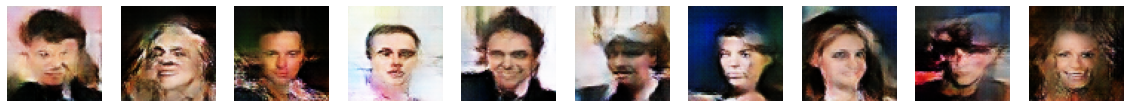

396/396 [==============================] - 994s 3s/step - c_loss: -3.0303 - c_wass_loss: -3.2663 - c_gp: 0.0236 - g_loss: 3.9655
Epoch 17/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.9673 - c_wass_loss: -3.1976 - c_gp: 0.0230 - g_loss: 4.6547
Saved to ./output/generated_img_016.png


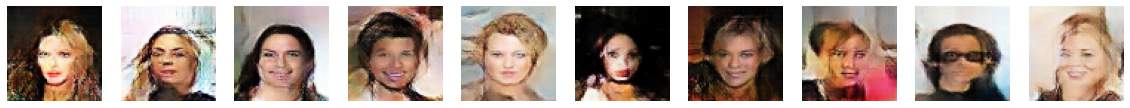

396/396 [==============================] - 996s 3s/step - c_loss: -2.9673 - c_wass_loss: -3.1976 - c_gp: 0.0230 - g_loss: 4.6547
Epoch 18/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.8965 - c_wass_loss: -3.1188 - c_gp: 0.0222 - g_loss: 4.6640
Saved to ./output/generated_img_017.png


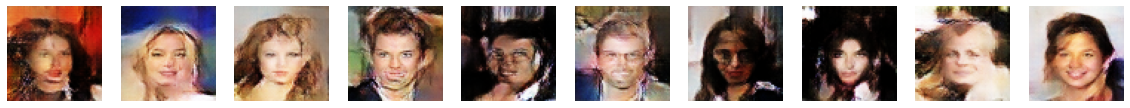

396/396 [==============================] - 996s 3s/step - c_loss: -2.8965 - c_wass_loss: -3.1188 - c_gp: 0.0222 - g_loss: 4.6640
Epoch 19/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.7673 - c_wass_loss: -2.9810 - c_gp: 0.0214 - g_loss: 4.9827
Saved to ./output/generated_img_018.png


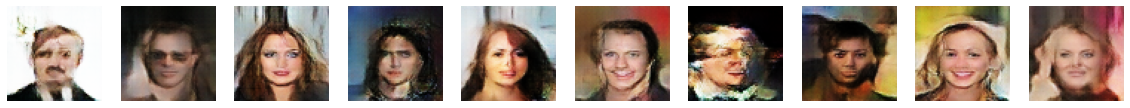

396/396 [==============================] - 996s 3s/step - c_loss: -2.7673 - c_wass_loss: -2.9810 - c_gp: 0.0214 - g_loss: 4.9827
Epoch 20/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.6545 - c_wass_loss: -2.8594 - c_gp: 0.0205 - g_loss: 4.6774
Saved to ./output/generated_img_019.png


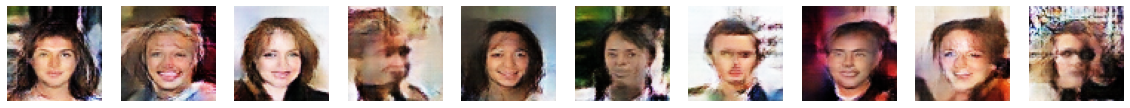

396/396 [==============================] - 995s 3s/step - c_loss: -2.6545 - c_wass_loss: -2.8594 - c_gp: 0.0205 - g_loss: 4.6774
Epoch 21/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.6853 - c_wass_loss: -2.8868 - c_gp: 0.0201 - g_loss: 4.0779
Saved to ./output/generated_img_020.png


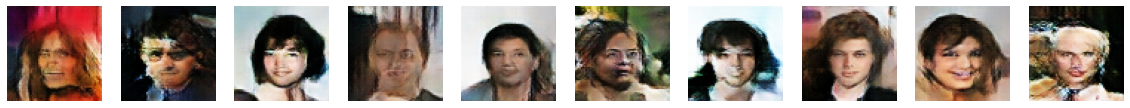

396/396 [==============================] - 996s 3s/step - c_loss: -2.6853 - c_wass_loss: -2.8868 - c_gp: 0.0201 - g_loss: 4.0779
Epoch 22/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.6172 - c_wass_loss: -2.8148 - c_gp: 0.0198 - g_loss: 3.8148
Saved to ./output/generated_img_021.png


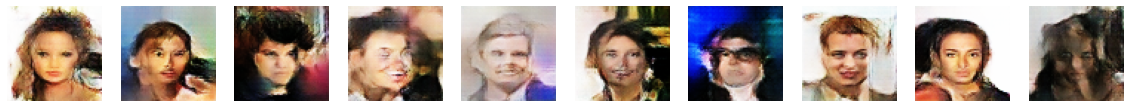

396/396 [==============================] - 995s 3s/step - c_loss: -2.6172 - c_wass_loss: -2.8148 - c_gp: 0.0198 - g_loss: 3.8148
Epoch 23/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.5806 - c_wass_loss: -2.7745 - c_gp: 0.0194 - g_loss: 3.2968
Saved to ./output/generated_img_022.png


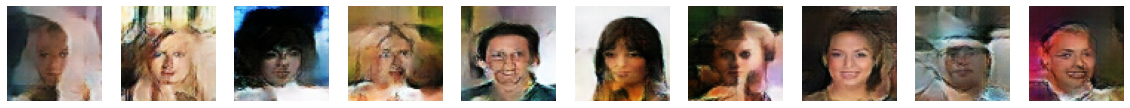

396/396 [==============================] - 996s 3s/step - c_loss: -2.5806 - c_wass_loss: -2.7745 - c_gp: 0.0194 - g_loss: 3.2968
Epoch 24/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.5213 - c_wass_loss: -2.7056 - c_gp: 0.0184 - g_loss: 4.8464
Saved to ./output/generated_img_023.png


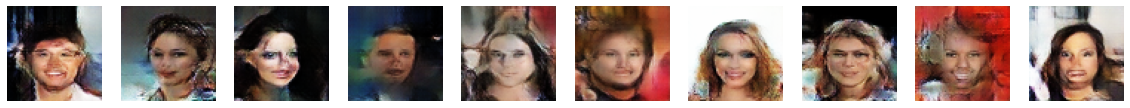

396/396 [==============================] - 996s 3s/step - c_loss: -2.5213 - c_wass_loss: -2.7056 - c_gp: 0.0184 - g_loss: 4.8464
Epoch 25/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.4253 - c_wass_loss: -2.6052 - c_gp: 0.0180 - g_loss: 4.9873
Saved to ./output/generated_img_024.png


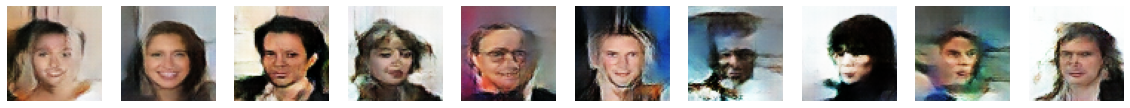

396/396 [==============================] - 995s 3s/step - c_loss: -2.4253 - c_wass_loss: -2.6052 - c_gp: 0.0180 - g_loss: 4.9873
Epoch 26/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.4003 - c_wass_loss: -2.5728 - c_gp: 0.0173 - g_loss: 3.9625
Saved to ./output/generated_img_025.png


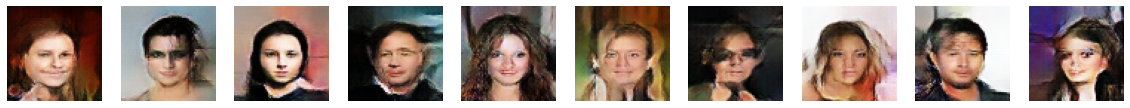

396/396 [==============================] - 995s 3s/step - c_loss: -2.4003 - c_wass_loss: -2.5728 - c_gp: 0.0173 - g_loss: 3.9625
Epoch 27/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.3416 - c_wass_loss: -2.5144 - c_gp: 0.0173 - g_loss: 3.4077
Saved to ./output/generated_img_026.png


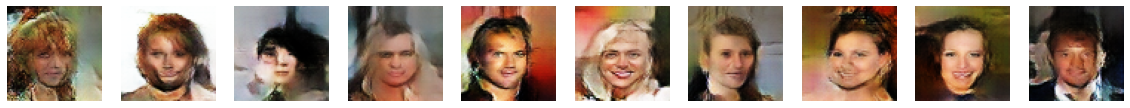

396/396 [==============================] - 995s 3s/step - c_loss: -2.3416 - c_wass_loss: -2.5144 - c_gp: 0.0173 - g_loss: 3.4077
Epoch 28/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.2830 - c_wass_loss: -2.4497 - c_gp: 0.0167 - g_loss: 2.2538
Saved to ./output/generated_img_027.png


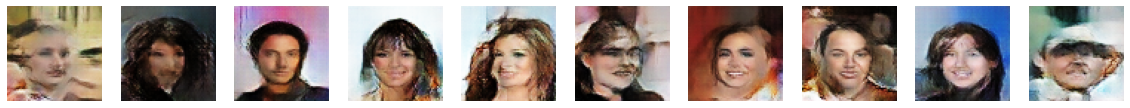

396/396 [==============================] - 996s 3s/step - c_loss: -2.2830 - c_wass_loss: -2.4497 - c_gp: 0.0167 - g_loss: 2.2538
Epoch 29/2000
396/396 [==============================] - ETA: 0s - c_loss: -2.2720 - c_wass_loss: -2.4319 - c_gp: 0.0160 - g_loss: 4.0663
Saved to ./output/generated_img_028.png


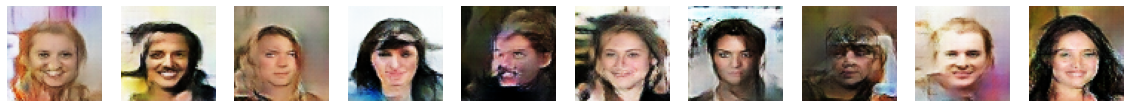

396/396 [==============================] - 996s 3s/step - c_loss: -2.2720 - c_wass_loss: -2.4319 - c_gp: 0.0160 - g_loss: 4.0663
Epoch 30/2000
198/396 [==============>...............] - ETA: 8:17 - c_loss: -2.2288 - c_wass_loss: -2.3857 - c_gp: 0.0157 - g_loss: 3.7057

In [ ]:
history = wgan.fit(
    train, 
    epochs=EPOCHS*100, 
    # steps_per_epoch = 10, 
    # initial_epoch = 39,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [20]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator/assets
INFO:tensorflow:Assets written to: ./models/critic/assets


## Generate images

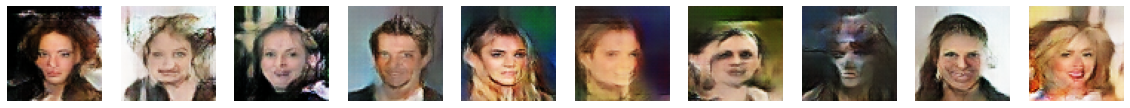

In [21]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgan.generator.predict(z_sample)
display(imgs, cmap = None)

## Compare images

In [26]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

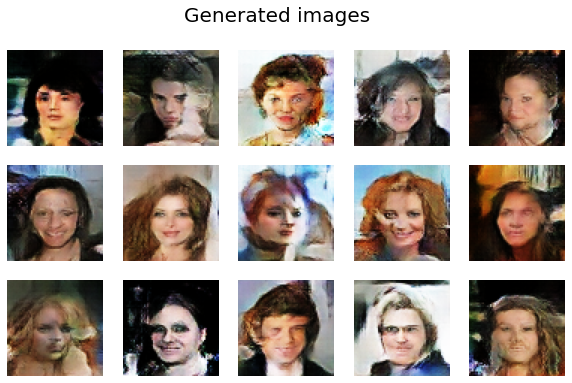

In [24]:
r, c = 3,5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle('Generated images', fontsize= 20)

noise = np.random.normal(size = (r * c, Z_DIM))
gen_imgs = (generator.predict(noise) + 1) * 0.5

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap=None)
        axs[i, j].axis("off")
        cnt += 1

plt.show()

NameError: name 'all_data' is not defined

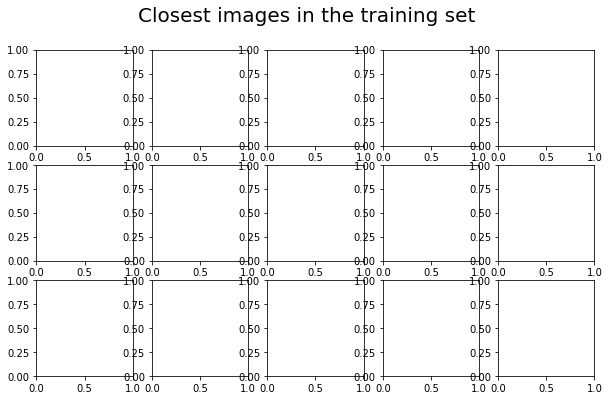

In [25]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle('Closest images in the training set', fontsize= 20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()